In [15]:
import sys,os
import pandas as pd
sys.path.insert(0, '/home/aai/ts.rcac/lib/python2.7/site-packages/tacc_stats-2.1.1-py2.7-linux-x86_64.egg')
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.figure import Figure
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import FigureCanvasPdf
%matplotlib inline
import new_total
import json
import imp
import numpy 
import new_user2
#import user_avg
from datetime import datetime, timedelta
from scipy import stats
import scipy

In [16]:
from ipywidgets import *
from IPython.display import display

plt.style.use('ggplot')

In [17]:
import glob

In [18]:
username = 'jbuzan'
#jbuzan
u = new_user2.User(username)

In [19]:
user_avg = u.user_avg[u.uid]
user_stderr = u.user_stderr[u.uid]
date_avg = u.date_avg[u.uid]
date_stderr = u.date_stderr[u.uid]
job_avg = u.job_avg[u.uid]
job_std = u.job_std[u.uid]
job_stderr = u.job_stderr[u.uid]
host_avg = u.host_avg[u.uid]
host_stderr =  u.host_stderr[u.uid]

In [23]:
def arange_date_job(date, stderr):
    #data: metrics--cluster--data three demensional list
    cl =[]
    data = []
    jobid = []
    std = []
    for m in u.metrics:
        data.append([])
        std.append([])
    for c in range(len(list(job_avg.keys()))):
        cluster = list(job_avg.keys())[c]
        if date in job_avg[cluster]:
            jobid.append([])
            cl.append(cluster)
    for c in range(len(cl)):
        cluster = cl[c]
        for job in job_avg[cluster][date]:
            jobid[c].append(job)
        for m in range(len(u.metrics)):
            met = u.metrics[m]
            for c in range(len(cl)):
                data[m].append([])
                std[m].append([])
                cluster = cl[c]
                for job in job_avg[cluster][date]:
                    data[m][c].append(job_avg[cluster][date][job][met])
                    std[m][c].append(stderr[cluster][date][job][met])
    return data, std, jobid, cl

In [24]:
def job_to_job(job):
    jjob = []
    for i in range(len(job)):
        jjob.append([])
        for j in range(len(job[i])):
            jj = int(job[i][j])
            jjob[i].append(jj)
    return jjob
def corresponding(job, std):
    index = {}
    for i in range(len(job)):
        index[job[i]] = std[i]
    c = sorted(job)
    new_std = []
    for i in range(len(c)):
        new_std.append(index[c[i]])
    return new_std
    

In [25]:
def plot_int_job(date, fig_x = 10, fig_y = 30, st ='stderr'):
    fig, ax = plt.subplots(nrows = len(u.metrics), ncols = 1, figsize = (fig_x, fig_y), sharex = True)
    fig.subplots_adjust(bottom=0.20)
    if st == 'stderr':
        std = job_stderr
    elif st == 'std':
        std = job_std
    else:
        print('wrong st input')
        pass
    color = ['cornflowerblue','tomato','mediumpurple','lightgreen','palevioletred']
    data, data_std, job, cluster = arange_date_job(date, std)
    j = job_to_job(job)
    leg = []
    for key in cluster:
        leg.append(key.split('.')[0])
    for m in range(len(u.metrics)):
        my_xticks = []
        xx = []
        for i in range(len(cluster)):
            label = cluster[i]
            value = data[m][i]
            for e in range(len(value)):
                if value[e] == False:
                    value[e] = 0
            sd = data_std[m][i]
            d = j[i]
            newstd = corresponding(d, sd)
            newavg = corresponding(d, value)
            
            newd = sorted(d)
            if i != 0:
                newd[0] = str('\n' + str(newd[0]))
            #print(newd)
            x = numpy.arange(len(newd))
            my_xticks.extend(newd)
            
            xx.extend(x)
            #plt.xticks(x, my_xticks)
            
            ax[m].errorbar(x, newavg, yerr = newstd, c = color[i], label = label)
            
        ax[m].set_ylabel(u.unit[m])
        ax[m].legend(leg, fontsize = 8, ncol = 3, loc = 'upper left')
        plt.xticks(xx, my_xticks)

In [26]:
total_date = []
for c in job_avg.keys():
    for date in job_avg[c]:
        if date not in total_date:
            total_date.append(date)
def date_to_date(dates):
    r = []
    for d in dates:
        date = datetime.strptime(d, '%Y-%m-%d')
        r.append(date)
    return r
def date_to_string(date):
    r = []
    for d in date:
        dd = d.strftime('%Y-%m-%d')
        r.append(dd)
    return r

In [27]:
ddate = date_to_date(total_date)
ddate.sort()
ddate_str = date_to_string(ddate)

In [28]:
def plot_int_bar(date, figsize_x = 10, figsize_y = 20, st ='stderr', width =0.5, rotat = '90'):
    
    if st == 'stderr':
        std = job_stderr
    elif st == 'std':
        std = job_std
    else:
        print('wrong st input')
        pass
    c = ['cornflowerblue','tomato','mediumpurple','lightgreen','palevioletred']
    data, data_std, job, cluster = arange_date_job(date, std)
    #print(cluster)
    fig, axes = plt.subplots(nrows = len(u.metrics), ncols = len(cluster), figsize = (figsize_x, figsize_y), sharex = False, squeeze=False)

    j = job_to_job(job)
    leg = []
    for key in cluster:
        leg.append(key.split('.')[0])
    for m in range(len(u.metrics)):
        axl = axes[m]
        for i in range(len(cluster)):
            ax = axl[i]
            label = cluster[i]
            value = data[m][i]
            for e in range(len(value)):
                if value[e] == False:
                    value[e] = 0
            sd = data_std[m][i]
            d = j[i]
            newstd = corresponding(d, sd)
            newavg = corresponding(d, value)
            newd = sorted(d)
            x = numpy.arange(len(newd))
            dlabel = newd
            #plt.xticks(x, my_xticks)
            ax.set_xticks(x + width/2)
            ax.set_xticklabels(dlabel, rotation = rotat)
            #print(c[i])
            ax.bar(x, newavg, width = width, color = c[i], yerr = newstd)
            ax.set_ylabel(u.unit[m])
            #ax.legend(leg, fontsize = 8, ncol = 3, loc = 'upper left')
            ax.set_title(cluster[i])


In [29]:
def plot_int_hist(date, figsize_x = 10, figsize_y = 20, numbins= 10, st ='stderr'):
    
    if st == 'stderr':
        std = job_stderr
    elif st == 'std':
        std = job_std
    else:
        print('wrong st input')
        pass
    c = ['cornflowerblue','tomato','mediumpurple','lightgreen','palevioletred']
    data, data_std, job, cluster = arange_date_job(date, std)
    #print(cluster)
    fig, axes = plt.subplots(nrows = len(u.metrics), ncols = len(cluster), figsize = (figsize_x, figsize_y), sharex = False, squeeze=False)

    j = job_to_job(job)
    leg = []
    for key in cluster:
        leg.append(key.split('.')[0])
    for m in range(len(u.metrics)):
        axl = axes[m]
        for i in range(len(cluster)):
            ax = axl[i]
            label = cluster[i]
            value = data[m][i]
            for e in range(len(value)):
                if value[e] == False:
                    value[e] = 0
            sd = data_std[m][i]
            d = j[i]
            newstd = corresponding(d, sd)
            newavg = corresponding(d, value)
            newd = sorted(d)
            x = numpy.arange(len(newd))
            dlabel = newd
            #plt.xticks(x, my_xticks)
            
            #print(c[i])
            ax.hist(newavg, numbins, color = c[i])
            ax.set_ylabel(u.unit[m])
            #ax.legend(leg, fontsize = 8, ncol = 3, loc = 'upper left')
            ax.set_title(cluster[i])


# Interaction plot at job_average level

In [36]:
d_selection = widgets.Select(description='Date chosen',options=ddate_str)

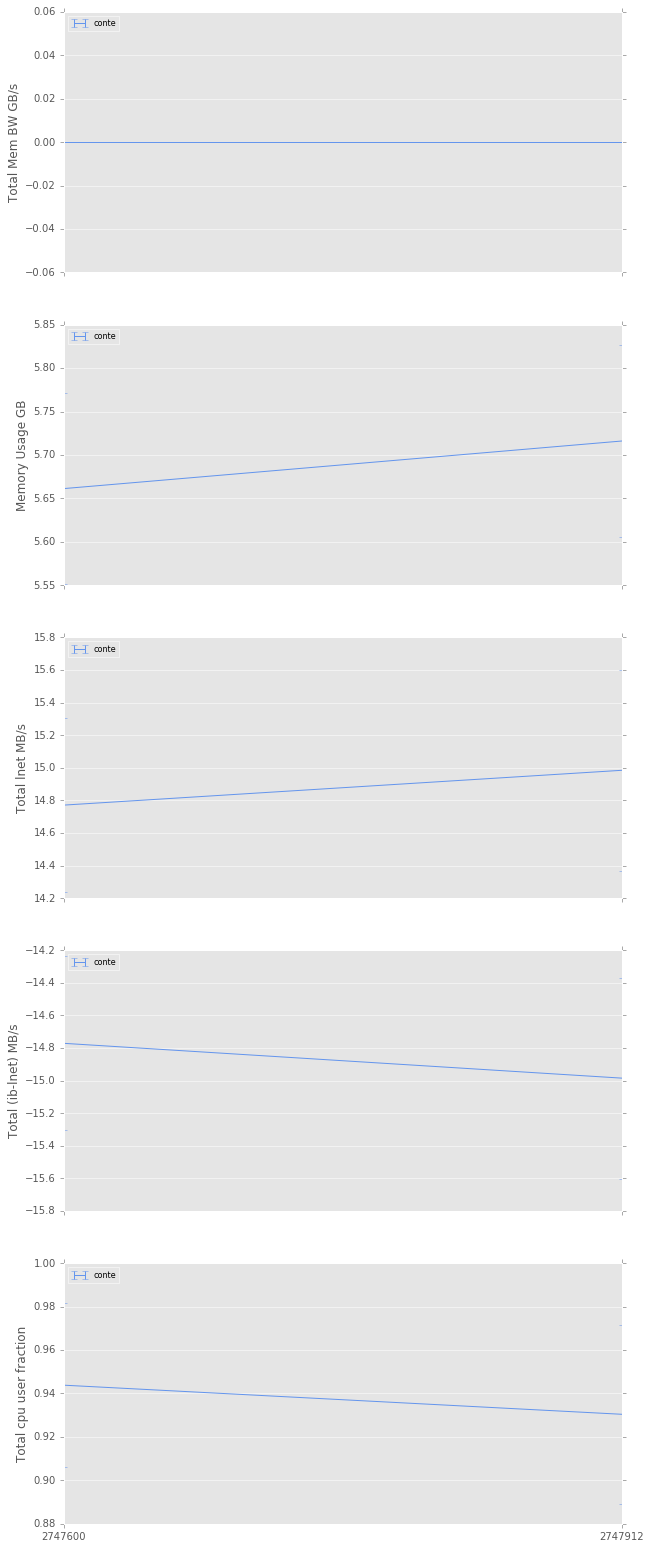

In [14]:
i = interact(plot_int_job, date = d_selection, fig_x = (10, 100, 5), fig_y = (10, 100, 5), st =['stderr', 'std'])

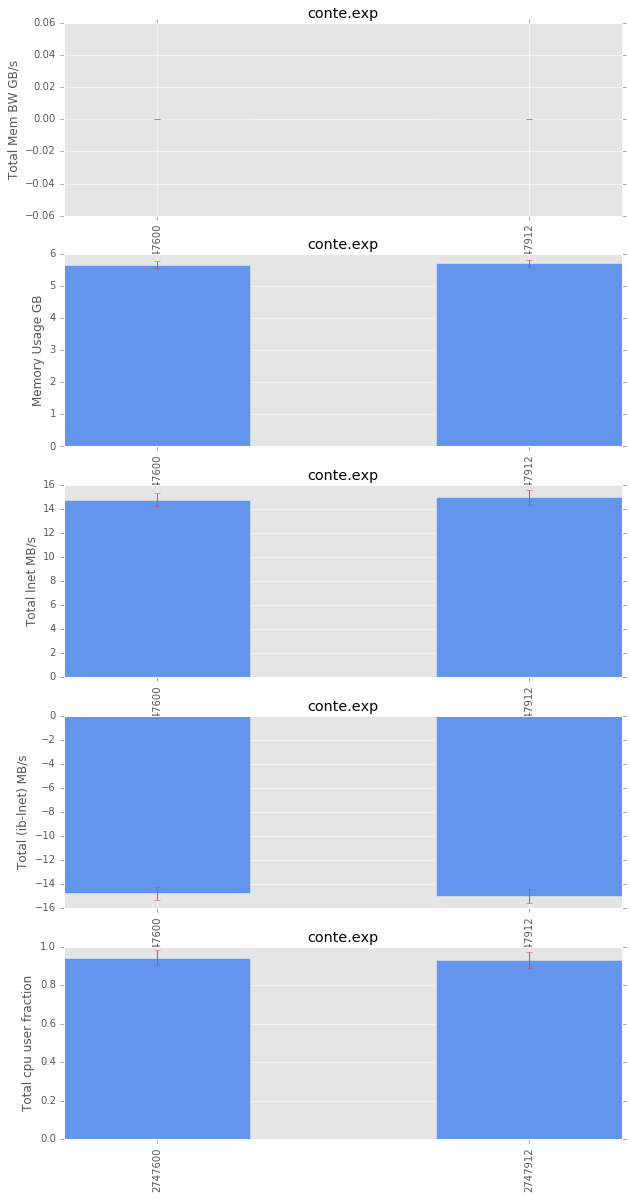

In [15]:
j = interact(plot_int_bar, date = d_selection,figsize_x = (10, 100, 1), figsize_y = (10, 100, 1), st =['stderr', 'std'], width = (0, 1, 0.1), rotation = (0, 90, 1))



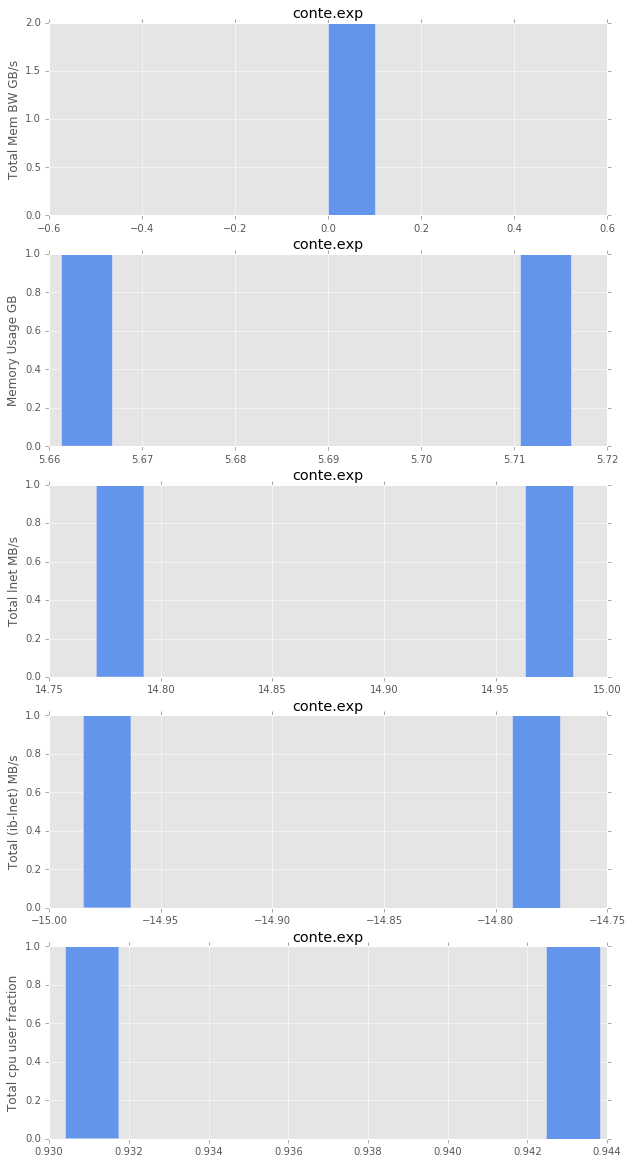

In [16]:
k = interact(plot_int_hist, date = d_selection,figsize_x = (10, 100, 1), figsize_y = (10, 100, 1),numbins = (1, 100, 1))

# interaction with data

In [30]:
def print_job_id(date):
    for cluster in job_avg.keys():
        if date in job_avg[cluster]:
            jobid = job_avg[cluster][date].keys()
            print("Jobids for {} on cluster {} are: {}\n".format(date, cluster, jobid))

In [31]:
def print_job_average(date, jobid):
    for cluster in job_avg.keys():
        if date in job_avg[cluster]:
            jobids = job_avg[cluster][date].keys()
            if jobid in jobids:
                avg = job_avg[cluster][date][jobid]
                print("Job average for job {} on {} on cluster {} are: {}\n".format(jobid, date, cluster, avg))

In [32]:
def get_job_widget(date):
    jobs =[]
    for cluster in job_avg:
        if date in job_avg[cluster]:
            jobs.extend(job_avg[cluster][date].keys())
    j_selection = widgets.Select(description='Date chosen',options=jobs)
    return j_selection

In [33]:
def arange_data_per_job(date, jobid):
    cl = []
    data = []
    host_list = []
    for m in u.metrics:
        data.append([])
    
    for cluster in u.data:
        if date in u.data[cluster]:
            if jobid in u.data[cluster][date]:
                if cluster not in cl:
                    cl.append(cluster)
                for m in u.metrics:
                    m_index = u.metrics.index(m)
                    for host in u.data[cluster][date][jobid]:
                        data[m_index].append([])
                        if host not in host_list:
                            host_list.append(host)
                        index = host_list.index(host)
                        data[m_index][index].extend(u.data[cluster][date][jobid][host][m])
    return cl, data, host_list

In [34]:
def plot_job(date= '2016-09-08', jobid = '332819', figsize_x= 10, figsize_y = 30):
    c = ['cornflowerblue','tomato','mediumpurple','lightgreen','palevioletred']
    cluster, data, host = arange_data_per_job(date, jobid)
    #print(cluster)
    fig, axes = plt.subplots(nrows = len(u.metrics), ncols = len(cluster), figsize = (figsize_x, figsize_y), sharex = False, squeeze=False)
    leg = []
    for key in cluster:
        leg.append(key.split('.')[0])
    for m in range(len(u.metrics)):
        axl = axes[m]
        for i in range(len(cluster)):
            ax = axl[i]
            label = cluster[i]
            for h in range(len(host)):
                value = data[m][i]
                
                x = numpy.arange(len(value))
                for xx in range(len(x)):
                    x[xx] = x[xx]* 5
                    
                dlabel = host[h]
            #plt.xticks(x, my_xticks)
            
            #print(c[i])
                ax.scatter(x, value, color = c[i], label = dlabel)
                ax.plot(x, value, color = c[i], label = dlabel)
            ax.set_ylabel(u.unit[m])
            ax.legend(host, fontsize = 8, ncol = 3, loc = 'upper left')
            ax.set_title(cluster[i] + ' (time in minutes)')

In [37]:
d1 = interact(print_job_id, date = d_selection)

Jobids for 2016-04-24 on cluster conte.exp are: dict_keys(['3684503', '3684810', '3684513', '3684440', '3685153', '3684450', '3684223', '3684338', '3684989', '3684162', '3684402', '3684838', '3684588', '3684583'])

Jobids for 2016-04-24 on cluster snyder.exp are: dict_keys(['132621', '132735', '132872', '132603', '132606', '132561', '132684', '132904', '132834', '132615', '132584', '132856', '132660', '132879', '132627', '132611', '132747', '132515', '132846', '132688', '132686', '132701', '132897', '132871', '132598', '132612', '132883', '132469', '132714', '132483', '132623', '132447', '132495', '132633', '132814', '132852', '132566', '132446', '132629', '132599', '132681', '132435', '132513', '132573', '132835', '132813', '132461', '132545', '132617', '132717', '132604', '132613', '132900', '132831', '132675', '132501', '132754', '132448', '132444', '132847', '132673', '132464', '132829', '132602', '132558', '132836', '132445', '132463', '132678', '132886', '132691', '132552', '1328

In [35]:
d1 = interact(print_job_average, date = d_selection, jobid = 'text')

Job average for job 255812 on 2016-07-13 on cluster snyder.exp are: {'cpu_user_fraction': 0.0106, 'MemBW': 0.1589919686317444, 'MemUsage': 14.665050506591797, 'ib-lnet': -0.00648040771484375, 'lnet': 0.00648040771484375}



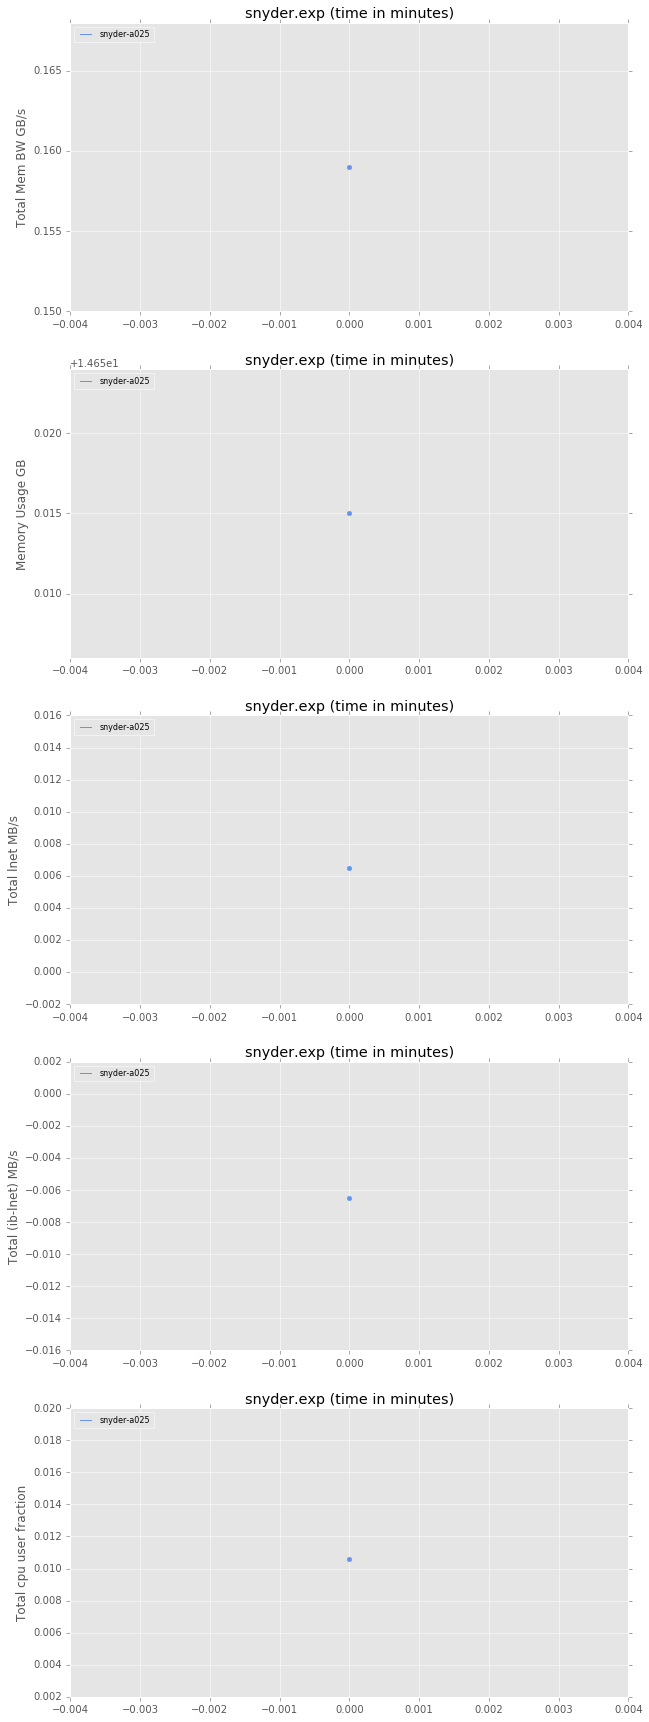

In [37]:
j_plot = interact(plot_job, date= d_selection, jobid = '332819', figsize_x = (10, 100, 1), figsize_y = (10, 100, 1))